## 8. EJERCICIO

Vamos a armar una pequeña competición en el curso.
El objetivo es armar una arquitectura de CNN que identifique el dataset MNIST.
Se van a usar capas de convolución, de activación y de pooling a elección. Cada alumno eligirá su modelo y los respectivos hiperparámetros, lo entrenará y presentará los siguientes resultados:

*   `test_acc` (del test final)
*   `n_parameter`
*   `n_layers` (conv + activacion + pooling = 1 capa)



El modelo se deberá ajustar a los siguientes parámetros:

*   train: 80%, validation: 10%, test: 10% (los datos serán dados así todos usan el mismo set para cada grupo. Están en el github el curso).
*   capa final de salida será una softmax de 10 elementos.
*   coss_function será `CrossEntropyLoss`.

El ganador de la competencia será aquel que consiga el mayor `score` empleando la siguietne fórmula:

$$ score = \frac{1}{log_{10}(n\_parameter)} *test\_acc*n\_layers$$

Deberan presentar su código colab funcionando y el score alcanzado (con los valores de cada variable que compone el score).

Es una competencia fairplay y con fines didácticos, esta formula del ```score``` fué inventada.... no usar como referencia para definir qué modelo utilizar.







#### Importar lo necesario

In [4]:
import torch
import torchvision
import numpy as np
import random
import matplotlib.pyplot as plt
from torchsummary import summary

#### configuramos el `device` acorde al device disponible




In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### 1. Cargar base de datos

In [6]:
# primero creamos el dataset
train_dataset = torchvision.datasets.MNIST('../data', train=True, download=True,
                       transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor()#,#<---------------- esto es GLORIOSO!!
                            #torchvision.transforms.Normalize((0.1307,), (0.3081,))
                            ])
                      )

test_dataset = torchvision.datasets.MNIST('../data', train=False,
                   transform=torchvision.transforms.Compose([
                        torchvision.transforms.ToTensor()#, #<------------------- esto es GLORIOSO!!
                        #torchvision.transforms.Normalize((0.1307,), (0.3081,))
                        ])
                     )

# ahora el dataloader
dataloader = {
    'train': torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)
}

### 2. Ver que la base de datos esté OK

In [7]:
print(type(dataloader))
print(type(dataloader['train']))

<class 'dict'>
<class 'torch.utils.data.dataloader.DataLoader'>


Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])
tamaño de 1 imagen:  torch.Size([1, 28, 28])
tamaño 1 imagen DESPUES de squeeze:  torch.Size([28, 28])


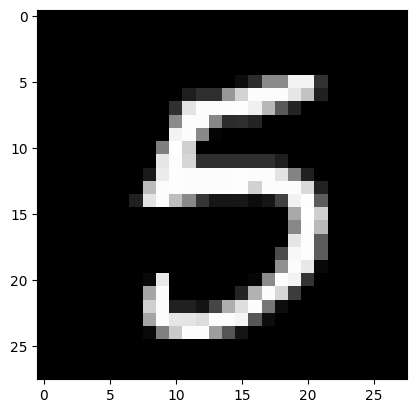

Label: 5


In [8]:
# Display image and label from dataloader (dataloader -> una herramienta para hacer batches de datasets)
train_features, train_labels = next(iter(dataloader['train']))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0]
print('tamaño de 1 imagen: ', img.shape)
# le QUITO 1 dimension (la del tamaño del batch) para poder graficar
img = train_features[0].squeeze()
print('tamaño 1 imagen DESPUES de squeeze: ', img.shape)
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

### 3. Construyo mi CNN

#### Bloque de convolución

defino primero un "bloque" de una capa CNN
construido con los bloques funcionales vistos en clase

(hiper)parámetros a pasar a la función:

  - `c_in`:   canales (kernels) de entrada
  - `c_out`:  canales (kernels) de salida
  - `k`:      tamaño del kernel kxk
  - `p`:      tamaño del padding de la convolución
  - `s`:      stride de la convolución
  - `pk`:     tamaño del kernel del pooling
  - `ps`:     stride de la pooling
  - `pp`:     padding en la pooling

la función pooling se elige directamente dentro del bloque!

In [9]:
# bloque de convolución para emplear en mi red

def conv_block(c_in, c_out, k=5, p=2, s=1, pk=3, ps=2, pp=1):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s), # conv
        torch.nn.Tanh(),                                      # activation
        torch.nn.MaxPool2d(pk, stride=ps, padding=pp)         # pooling
    )


### Red convolucional (modelo)


Ahora SI construyo mi red... usando la clase CNN de pytorch
revisar muy bien las dimensiones a emplear en cada capa y
tener presente la reducción de las dimensiones.

En la útlima capa fully conected `fc`, hacer bien el cálculo final del
tamaño del array que se obtiene siguiendo la formula vista en la teoria
tanto para la capa conv como para la capa pooling.

In [10]:
class CNN(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = conv_block(n_channels, 8)
    self.conv1_out = None
    self.conv2 = conv_block(8, 16)
    self.conv2_out = None
    self.conv3 = conv_block(16, 32)
    self.conv3_out = None
    # self.conv4 = conv_block(128, 128)
    # self.conv4_out = None
    self.fc = torch.nn.Linear(512, n_outputs) # verificar la dim de la salida para calcular el tamaño de la fully conected!!
    #self.sm = torch.nn.Softmax(dim=1)


    print('Red creada')
    print('arquitectura:')
    print(self)

    # Me fijo en el número de capas
    i=0
    for layer in self.children():
        i=i+1
    print('Número total de capas de CNN (conv+act+polling) + finales : ', i)

    # Me fijo en el número de parámetros entrenables
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Número total de parámetros a entrenar: ', pytorch_total_params)

  def validar_dim(self):
    # es una funcion "forward" que imprime la dimension de cada paso
    # la defino distinto de la forward standard para que cuando entrenemos
    # no nos llene la pantalla de información inecesaria.

    print("Validacion de dimensiones")
    tam = input("Ingrese tamaño de entrada: ")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Tamaño entrada: ", x.shape)

    x = self.conv1(x)
    print("Tamaño salida conv1: ", x.shape)
    x = self.conv2(x)
    print("Tamaño salida conv2: ", x.shape)
    x = self.conv3(x)
    print("Tamaño salida conv3: ", x.shape)

    # x = self.conv4(x)
    # print("Tamaño salida conv4: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Tamaño imagen vectorizada: ", x.shape)
    x = self.fc(x)
    print("Tamaño salida fc (nro clases): ", x.shape)

  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.conv2_out = self.conv2(self.conv1_out)
    self.conv3_out = self.conv3(self.conv2_out)
    # self.conv4_out = self.conv4(self.conv3_out)
    y = self.conv3_out.view(self.conv3_out.shape[0], -1)
    y = self.fc(y)
    # x = self.sm(x)
    return y

In [11]:
model = CNN()

Red creada
arquitectura:
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=512, out_features=10, bias=True)
)
Número total de capas de CNN (conv+act+polling) + finales :  4
Número total de parámetros a entrenar:  21386


In [12]:
summary(model.cuda(),(1, 28, 28) )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]             208
              Tanh-2            [-1, 8, 28, 28]               0
         MaxPool2d-3            [-1, 8, 14, 14]               0
            Conv2d-4           [-1, 16, 14, 14]           3,216
              Tanh-5           [-1, 16, 14, 14]               0
         MaxPool2d-6             [-1, 16, 7, 7]               0
            Conv2d-7             [-1, 32, 7, 7]          12,832
              Tanh-8             [-1, 32, 7, 7]               0
         MaxPool2d-9             [-1, 32, 4, 4]               0
           Linear-10                   [-1, 10]           5,130
Total params: 21,386
Trainable params: 21,386
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.19
Params size (MB): 0.08
Estimated Tot

## 4. Veamos que las dimensiones sean consistentes.

In [25]:
model.cpu()
model.validar_dim()

Validacion de dimensiones
Tamaño entrada:  torch.Size([1, 1, 28, 28])
Tamaño salida conv1:  torch.Size([1, 8, 14, 14])
Tamaño salida conv2:  torch.Size([1, 16, 7, 7])
Tamaño salida conv3:  torch.Size([1, 32, 4, 4])
Tamaño imagen vectorizada:  torch.Size([1, 512])
Tamaño salida fc (nro clases):  torch.Size([1, 10])


In [13]:
from tqdm import tqdm # <- para graficar la barra de avance


def fit(model, dataloader, epochs=15):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = torch.nn.CrossEntropyLoss()
    epoch_t_loss = []
    epoch_v_loss = []
    epoch_t_acc = []
    epoch_v_acc = []
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            ####
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")

        epoch_t_loss.append(np.mean(train_loss))
        epoch_t_acc.append(np.mean(train_acc))

        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

        epoch_v_loss.append(np.mean(val_loss))
        epoch_v_acc.append(np.mean(val_acc))

    plt.figure()
    plt.plot(epoch_t_loss, 'r')
    plt.plot(epoch_v_loss, 'g')
    plt.title('loss')
    plt.legend(['train loss', 'val loss'])
    plt.grid()

    plt.figure()
    plt.plot(epoch_t_acc, 'r')
    plt.plot(epoch_v_acc, 'g')
    plt.title('acc')
    plt.legend(['train acc', 'val acc'])
    plt.grid()
    plt.show()

## 6. Entreno la red

val_loss 0.16813 val_acc 0.95223: 100%|██████████| 157/157 [00:02<00:00, 62.96it/s]


Epoch 1/5 loss 0.24540 val_loss 0.16813 acc 0.93309 val_acc 0.95223


val_loss 0.12235 val_acc 0.96328: 100%|██████████| 157/157 [00:02<00:00, 64.14it/s]


Epoch 2/5 loss 0.15861 val_loss 0.12235 acc 0.95512 val_acc 0.96328


val_loss 0.09711 val_acc 0.97084: 100%|██████████| 157/157 [00:02<00:00, 60.94it/s]


Epoch 3/5 loss 0.12239 val_loss 0.09711 acc 0.96410 val_acc 0.97084


val_loss 0.08178 val_acc 0.97502: 100%|██████████| 157/157 [00:02<00:00, 61.94it/s]


Epoch 4/5 loss 0.10091 val_loss 0.08178 acc 0.97027 val_acc 0.97502


val_loss 0.07088 val_acc 0.97830: 100%|██████████| 157/157 [00:02<00:00, 62.56it/s]


Epoch 5/5 loss 0.08717 val_loss 0.07088 acc 0.97403 val_acc 0.97830


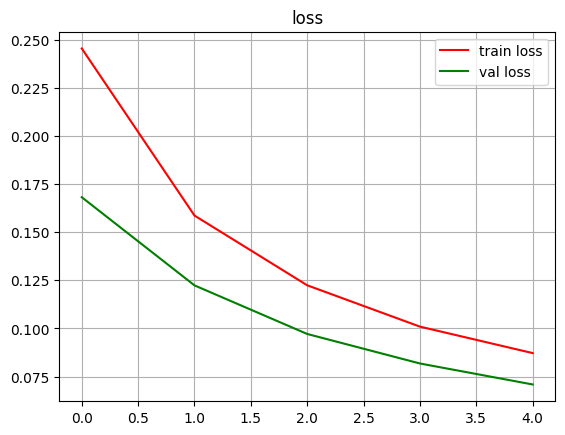

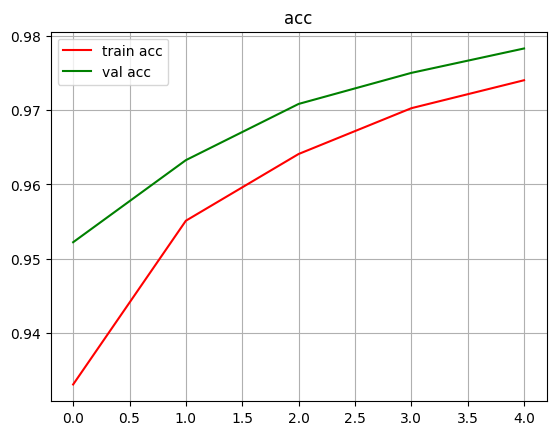

In [22]:
fit(model, dataloader, epochs=5)

In [23]:
model.eval()

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

...

# score final

$$ score = \frac{1}{log_{10}(n\_parameter)} *test\_acc*n\_layers$$

In [17]:
mode

<bound method Module.parameters of CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=512, out_features=10, bias=True)
)>